In [1]:
using RecurrenceCoefficients, Plots, LinearAlgebra, Elliptic, Elliptic.Jacobi, Random, LaTeXStrings, ApproxFun, Printf

### Necessary functions

In [2]:
M = (a,b) ->  (x -> (b-a)/2*(x .+ (b+a)/(b-a)))
iM = (a,b) -> (x -> 2/(b-a)*(x .- (b+a)/2))

#5 (generic function with 1 method)

In [3]:
function special_weight_int(bands)
    special_h = get_special_h(bands)
    g = size(bands,1)-1
    int = 0
    for j = 1:g
        f = Fun( z -> special_h(j)(z)*(z-bands[j,1]),bands[j,1]..bands[j,2])
        int += coefficients(f)[1]*π
    end
    f = Fun( z -> special_h(g+1)(z)*(z-bands[g+1,1])*(bands[g+1,2]-z),bands[g+1,1]..bands[g+1,2])
    int += coefficients(f)[1]*π
    real(int)
end

special_weight_int (generic function with 1 method)

In [4]:
function akh_iter(A,b,avec,bvec,ints,int0;x0=nothing,maxiter=250,tol=10^-12)
    N = length(b)
    x = zeros(N)
    if x0 == nothing
        x0 = zeros(N)
    end
    b -= A*x0
    r = b
    j = 0
    nb = norm(b)
    residvec = [norm(r)/nb]
    while norm(r)/nb>tol && j<maxiter
        if j == 0
            global y = b
        elseif j == 1
            global y = (A*ym1-avec[1]*ym1)/bvec[1]
            global ym2 = ym1
        else
            global y = -(bvec[j-1]*ym2+avec[j]*ym1-A*ym1)/bvec[j]
            global ym2 = ym1
        end
        x += real(ints[j+1]*2π*im)*y/int0
        #println(real(ints[j+1]*2π*im))
        r = b - A*x
        global ym1 = y
        append!(residvec,norm(r)/nb)
        #println(norm(r))
        j += 1
    end
    x += x0
    (x,residvec)
end

akh_iter (generic function with 1 method)

In [5]:
function mat_polys(A,b,avec,bvec,maxiter)
    polynorms = zeros(maxiter+1)
    for j = 0:maxiter
        if j == 0
            global y = b
        elseif j == 1
            global y = (A*ym1-avec[1]*ym1)/bvec[1]
            global ym2 = ym1
        else
            global y = -(bvec[j-1]*ym2+avec[j]*ym1-A*ym1)/bvec[j]
            global ym2 = ym1
        end
        global ym1 = y
        polynorms[j+1] = norm(y,Inf)
    end
    polynorms,y
end

mat_polys (generic function with 1 method)

In [6]:
function est_growth(A,avec,bvec;maxiter=150,maxrestarts=15,polydist=75)
    b = rand(size(A,1))
    growths = zeros(maxrestarts)
    for j = 1:maxrestarts
        (polygrowth,y) = mat_polys(A,b,avec,bvec,maxiter)
        b = y/norm(y,Inf)
        #growths[j] = (polygrowth[end]/polygrowth[end-1]+polygrowth[end-1]/polygrowth[end-2]+polygrowth[end-2]/polygrowth[end-3]+polygrowth[end-3]/polygrowth[end-4]+polygrowth[end-4]/polygrowth[end-5])/5
        #growths[j] = sqrt(polygrowth[end]/polygrowth[end-1])
        growths[j] = (polygrowth[end]/polygrowth[end-polydist])^(1/polydist)
    end
    growths
end

est_growth (generic function with 1 method)

In [7]:
function est_evec(A,avec,bvec;maxiter=150,maxrestarts=15)
    b = rand(size(A,1))
    growths = zeros(maxrestarts)
    for j = 1:maxrestarts
        (~,y) = mat_polys(A,b,avec,bvec,maxiter)
        b = y/norm(y,Inf)
    end
    (b'*A*b)/(b'*b)
end

est_evec (generic function with 1 method)

In [8]:
function bisection(f, a, b; tol=1e-12, max_iter=50)
    if f(a) * f(b) >= 0
        #error("Function has the same sign at both endpoints. Bisection method cannot be applied.")
        return argmax(f, [a b])
    end
    
    for iter in 1:max_iter
        c = (a + b) / 2
        if abs(f(c)) < tol
            return c
        end
        
        if f(a) * f(c) < 0
            b = c
        else
            a = c
        end
    end
    
    #error("Bisection method did not converge after $max_iter iterations.")
    return c
end

bisection (generic function with 1 method)

In [374]:
function optim_bands(bands,A,b,γₒ,γᵢ;maxiter=10,maxgrowth=1.2, maxrate=1.05, maxpoly=270,polydist=135)
    for j = 0:maxiter
        aveca = get_a(bands,0:maxpoly)
        bveca = get_b(bands,0:maxpoly)
        (polygrowth,~) = mat_polys(A,b,aveca,bveca,maxpoly)
        grate = (polygrowth[end]/polygrowth[end-polydist])^(1/polydist)
        if polygrowth[end]<maxgrowth*norm(b) || grate<maxrate
            return bands
        end
        #grate = (polygrowth[end]/polygrowth[end-1]+polygrowth[end-1]/polygrowth[end-2]+polygrowth[end-2]/polygrowth[end-3]+polygrowth[end-3]/polygrowth[end-4]+polygrowth[end-4]/polygrowth[end-5])/5
        grate = (polygrowth[end]/polygrowth[end-polydist])^(1/polydist)
        
        fbi(x) = abs(expg(bands,x))-grate
        bandsn = zeros(2,2)
        bandsn[1,1] = bisection(fbi, γₒ*bands[1,1], bands[1,1])
        bandsn[1,2] = bisection(fbi, bands[1,2], γᵢ*bands[1,2])
        bandsn[2,1] = bisection(fbi, γᵢ*bands[2,1], bands[2,1])
        bandsn[2,2] = bisection(fbi, bands[2,2], γₒ*bands[2,2])
        bands = copy(bandsn)
    end
    @printf("Polynomials still growing after %i iterations",maxiter)
    bands
end

optim_bands (generic function with 1 method)

In [375]:
function optim_bands_improved(bands,A,b,γₒ,γᵢ;maxiter=10,maxgrowth=1.2, maxrate=1.05, maxpoly=270, polydist=135)
    for j = 0:maxiter
        aveca = get_a(bands,0:maxpoly)
        bveca = get_b(bands,0:maxpoly)
        (polygrowth,~) = mat_polys(A,b,aveca,bveca,maxpoly)
        grate = (polygrowth[end]/polygrowth[end-polydist])^(1/polydist)
        if polygrowth[end]<maxgrowth*norm(b) || grate<maxrate
            return bands
        end
        fbi(x) = abs(expg(bands,x))-grate
        #fbi(x) = abs(p(bands,maxpoly+1,x)/p(bands,maxpoly,x))-grate
        bandsn = copy(bands)

        bandsn[1,1] = bisection(fbi, γₒ*bands[1,1], bands[1,1])
        #println("bandsn:\n",bandsn)
        #println("bands:\n",bands)
        avecan = get_a(bandsn,0:maxpoly)
        bvecan = get_b(bandsn,0:maxpoly)
        (polygrowthn,~) = mat_polys(A,b,avecan,bvecan,maxpoly)
        graten = (polygrowthn[end]/polygrowthn[end-polydist])^(1/polydist)
        #graten = est_growth(A,avecan,bvecan;maxiter=maxpoly)[end]
        #println("graten:\n",graten)
        #println("grate:\n",grate)
        if graten < grate
            bands = copy(bandsn)
            aveca = avecan
            bveca = bvecan
            polygrowth = polygrowthn
            grate = graten
            #println("here 1")
            if polygrowth[end]<maxgrowth*norm(b) || grate<maxrate
                return bands
            end
        else
            bandsn = copy(bands)
        end
        #println(bands)
        
        bandsn[1,2] = bisection(fbi, bands[1,2], γᵢ*bands[1,2])
        #println("bandsn:\n",bandsn)
        #println("bands:\n",bands)
        avecan = get_a(bandsn,0:maxpoly)
        bvecan = get_b(bandsn,0:maxpoly)
        
        (polygrowthn,~) = mat_polys(A,b,avecan,bvecan,maxpoly)
        graten = (polygrowthn[end]/polygrowthn[end-polydist])^(1/polydist)
        #graten = est_growth(A,avecan,bvecan;maxiter=maxpoly)[end]
        #println("graten:\n",graten)
        #println("grate:\n",grate)
        if graten < grate
            bands = copy(bandsn)
            aveca = avecan
            bveca = bvecan
            polygrowth = polygrowthn
            grate = graten
            #println("here 2")
            if polygrowth[end]<maxgrowth*norm(b) || grate<maxrate
                return bands
            end
        else
            bandsn = copy(bands)
        end
        #println(bands)
        
        bandsn[2,1] = bisection(fbi, γᵢ*bands[2,1], bands[2,1])
        #println("bandsn:\n",bandsn)
        #println("bands:\n",bands)
        avecan = get_a(bandsn,0:maxpoly)
        bvecan = get_b(bandsn,0:maxpoly)
        (polygrowthn,~) = mat_polys(A,b,avecan,bvecan,maxpoly)
        graten = (polygrowthn[end]/polygrowthn[end-polydist])^(1/polydist)
        #graten = est_growth(A,avecan,bvecan;maxiter=maxpoly)[end]
        #println("graten:\n",graten)
        #println("grate:\n",grate)
        if graten < grate
            bands = copy(bandsn)
            aveca = avecan
            bveca = bvecan
            polygrowth = polygrowthn
            grate = graten
            if polygrowth[end]<maxgrowth*norm(b) || grate<maxrate
                return bands
            end            #println("here 3")
        else
            bandsn = copy(bands)
        end
        #println(bands)
        
        bandsn[2,2] = bisection(fbi, bands[2,2], γₒ*bands[2,2])
        #println("bandsn:\n",bandsn)
        #println("bands:\n",bands)
        avecan = get_a(bandsn,0:maxpoly)
        bvecan = get_b(bandsn,0:maxpoly)
        (polygrowthn,~) = mat_polys(A,b,avecan,bvecan,maxpoly)
        graten = (polygrowthn[end]/polygrowthn[end-polydist])^(1/polydist)
        #graten = est_growth(A,avecan,bvecan;maxiter=maxpoly)[end]
        #println("graten:\n",graten)
        #println("grate:\n",grate)
        if graten < grate
            bands = copy(bandsn)
            aveca = avecan
            bveca = bvecan
            polygrowth = polygrowthn
            grate = graten
            if polygrowth[end]<maxgrowth*norm(b) || grate<maxrate
                return bands
            end            #println("here 4")
        else
            bandsn = copy(bands)
        end
        #println(bands)
        
        #bands = bandsn
    end
    @printf("Polynomials still growing after %i iterations",maxiter)
    bands
end

optim_bands_improved (generic function with 1 method)

In [177]:
function optim_bands_ev(bands,A;maxrestarts=15,maxpoly=150,tol=1e-15)
    for j = 1:4
        avec = get_a(bands,0:maxpoly)
        bvec = get_b(bands,0:maxpoly)
        nb = est_evec(Ap,avec,bvec;maxiter=maxpoly,maxrestarts=maxrestarts)
        if bands[1,1]<=nb<=bands[1,2] || bands[2,1]<=nb<=bands[2,2]
            return bands
        elseif nb<bands[1,1]
            bands[1,1] = nb-tol
        elseif bands[1,2]<nb<0.
            bands[1,2] = nb+tol
        elseif 0<nb<bands[2,1]
            bands[2,1] = nb-tol
        elseif nb>bands[2,2]
            bands[2,2] = nb+tol
        else
            println("Error: estimated eigenvalue is zero.")
        end
    end
    bands
end

optim_bands_ev (generic function with 1 method)

In [12]:
function akh_func(f,A,b,ctrpts,weights,avec,bvec,ints,int0;maxiter=250)
    N = length(b)
    fAb = zeros(N)
    for j = 1:length(ctrpts)
        x = zeros(N)
        for k = 0:maxiter-1
            if k == 0
                global y = b
            elseif k == 1
                global y = (A*ym1-avec[1]*ym1)/bvec[1]
                global ym2 = ym1
            else
                global y = -(bvec[k-1]*ym2+avec[k]*ym1-A*ym1)/bvec[k]
                global ym2 = ym1
            end
            x -= ints[k+1,j]*y/int0
            global ym1 = y
        end
        fAb += f(ctrpts[j])*weights[j]*x
    end
    fAb
end

akh_func (generic function with 1 method)

In [13]:
function akh_func_hist(f,A,b,ctrpts,weights,avec,bvec,ints,int0;maxiter=250)
    N = length(b)
    fAb = zeros(N)
    hist = zeros(ComplexF64,N,maxiter)
    for k = 0:maxiter-1
        if k == 0
            global y = b
        elseif k == 1
            global y = (A*ym1-avec[1]*ym1)/bvec[1]
            global ym2 = ym1
        else
            global y = -(bvec[k-1]*ym2+avec[k]*ym1-A*ym1)/bvec[k]
            global ym2 = ym1
        end
        global ym1 = y
        for j = 1:length(ctrpts)
            x = -ints[k+1,j]*y/int0
            fAb += f(ctrpts[j])*weights[j]*x
        end
        hist[:,k+1] = fAb
    end
    (fAb,hist)
end

akh_func_hist (generic function with 1 method)

In [14]:
const D1MACH1 = floatmin(Float64)
const D1MACH2 = floatmax(Float64)
const D1MACH3 = eps(Float64)/2
const D1MACH4 = eps(Float64)
const D1MACH5 = log10(2.)

#***BEGIN PROLOGUE  DRF
#***PURPOSE  Compute the incomplete or complete elliptic integral of the
#            1st kind.  For X, Y, and Z non-negative and at most one of
#            them zero, RF(X,Y,Z) = Integral from zero to infinity of
#                                -1/2     -1/2     -1/2
#                      (1/2)(t+X)    (t+Y)    (t+Z)    dt.
#            If X, Y or Z is zero, the integral is complete.
#***LIBRARY   SLATEC
#***CATEGORY  C14
#***TYPE      DOUBLE PRECISION (RF-S, DRF-D)
#***KEYWORDS  COMPLETE ELLIPTIC INTEGRAL, DUPLICATION THEOREM,
#             INCOMPLETE ELLIPTIC INTEGRAL, INTEGRAL OF THE FIRST KIND,
#             TAYLOR SERIES
#***AUTHOR  Carlson, B. C.
#             Ames Laboratory-DOE
#             Iowa State University
#             Ames, IA  50011
#           Notis, E. M.
#             Ames Laboratory-DOE
#             Iowa State University
#             Ames, IA  50011
#           Pexton, R. L.
#             Lawrence Livermore National Laboratory
#             Livermore, CA  94550

function DRF(X::ComplexF64, Y::ComplexF64, Z::Float64)

    ERRTOL = (4.0*D1MACH3)^(1.0/6.0)
    LOLIM  = 5.0 * D1MACH1
    UPLIM  = D1MACH2/5.0
    C1 = 1.0/24.0
    C2 = 3.0/44.0
    C3 = 1.0/14.0

    ans = 0.0
    #=if min(X,Y,Z) < 0.0
        return ans, 1
    end

    if max(X,Y,Z) > UPLIM
        return ans, 3
    end

    if min(X+Y,X+Z,Y+Z) < LOLIM
        return ans, 2
end=#

    XN = X
    YN = Y
    ZN = Z
    MU = 0.
    XNDEV = 0.
    YNDEV = 0.
    ZNDEV = 0.

    while true
        MU = (XN+YN+ZN)/3.0
        XNDEV = 2.0 - (MU+XN)/MU
        YNDEV = 2.0 - (MU+YN)/MU
        ZNDEV = 2.0 - (MU+ZN)/MU
        EPSLON = max(abs(XNDEV),abs(YNDEV),abs(ZNDEV))
        if (EPSLON < ERRTOL) break end
        XNROOT = sqrt(XN)
        YNROOT = sqrt(YN)
        ZNROOT = sqrt(ZN)
        LAMDA = XNROOT*(YNROOT+ZNROOT) + YNROOT*ZNROOT
        XN = (XN+LAMDA)*0.250
        YN = (YN+LAMDA)*0.250
        ZN = (ZN+LAMDA)*0.250
    end

    E2 = XNDEV*YNDEV - ZNDEV*ZNDEV
    E3 = XNDEV*YNDEV*ZNDEV
    S  = 1.0 + (C1*E2-0.10-C2*E3)*E2 + C3*E3
    ans = S/sqrt(MU)

    return ans, 0
end

DRF (generic function with 1 method)

In [15]:
function rawF(sinphi::ComplexF64, m::Float64)
    if abs(sinphi) == 1. && m == 1. return sign(sinphi)*Inf end
    sinphi2 = sinphi^2
    drf,ierr = DRF(1. - sinphi2, 1. - m*sinphi2, 1.)
    @assert ierr == 0
    sinphi*drf
end

function Elliptic.F(phi::ComplexF64, m::Float64)
    if isnan(phi) || isnan(m) return NaN end
    if m < 0. || m > 1. throw(DomainError(m, "argument m not in [0,1]")) end
    if abs(real(phi)) > pi/2
        # Abramowitz & Stegun (17.4.3)
        phi2 = real(phi) + pi/2
        return 2*fld(phi2,pi)*Elliptic.K(m) - rawF(cos(mod(phi2,pi)+imag(phi)im), m)
    end
    rawF(sin(phi), m)
end

In [16]:
function θ₁(z,q)
    res = 0
    τ=log(q)/(pi*im)
    #error bound from  Labrande (2015)
    maxiter = ceil(sqrt(66/(pi*imag(τ)*log(2,exp(1)))))+1 |> Int
    for n = 0:maxiter
        res += 2*(-1)^n*q^((n+1/2)^2)*sin(z*(2n+1))
    end
    res
end

θ₁ (generic function with 1 method)

In [17]:
function dθ₁(z,q)
    res = 0
    τ=log(q)/(pi*im)
    #error bound from  Labrande (2015)
    maxiter = ceil(sqrt(66/(pi*imag(τ)*log(2,exp(1)))))+1 |> Int
    for n = 0:maxiter
        res += (2n+1)*2*(-1)^n*q^((n+1/2)^2)*cos(z*(2n+1))
    end
    res
end

dθ₁ (generic function with 1 method)

In [18]:
function θ₄(z,q)
    res = 1
    τ=log(q)/(pi*im)
    #error bound from  Labrande (2015)
    maxiter = ceil(sqrt(66/(pi*imag(τ)*log(2,exp(1)))))+1 |> Int
    for n = 1:maxiter
        res += 2*(-1)^n*q^(n^2)*cos(z*2n)
    end
    res
end

θ₄ (generic function with 1 method)

In [19]:
function dθ₄(z,q)
    res = 0
    τ=log(q)/(pi*im)
    #error bound from  Labrande (2015)
    maxiter = ceil(sqrt(66/(pi*imag(τ)*log(2,exp(1)))))+1 |> Int
    for n = 1:maxiter
        res += -4n*(-1)^n*q^(n^2)*sin(z*2n)
    end
    res
end

dθ₄ (generic function with 1 method)

In [20]:
d2sn(x,m) = -m*(Elliptic.Jacobi.cn(x,m))^2*Elliptic.Jacobi.sn(x,m)-Elliptic.Jacobi.sn(x,m)*(Elliptic.Jacobi.dn(x,m)^2)

d2sn (generic function with 1 method)

In [21]:
function CIp(bands,n,x)
    α = iM(bands[1,1],bands[2,2])(bands[1,2])
    β = iM(bands[1,1],bands[2,2])(bands[2,1])
    
    k = sqrt(2*(β-α)/((1-α)*(1+β)))
    ρ = Elliptic.F(asin(√((1-α)/2)),k^2)
    
    K = Elliptic.K(k^2)
    Kp = Elliptic.K(1-k^2)
    q = exp(-π*Kp/K)
    
    Θ(x) = θ₄(x*π/(2K),q)
    H(x) = θ₁(x*π/(2K),q)
    Cₙ(n) = n==0 ? 1.0 : √2*Θ(ρ)/(√(Θ(ρ*(2n-1)))*√(Θ(ρ*(2n+1))))
    
    xx = iM(bands[1,1],bands[2,2])(x)
    if xx == α
        u = Kp*im
    else
        snu = √((α-1)*(1+xx)/(2*(α-xx)) |> Complex)#√(α-1 |> Complex)*√(1+x |> Complex)/√(2*(α-x) |> Complex)
        u = Elliptic.F(asin(snu),k^2)
    end
    int = -(1/(2im*π))*Cₙ(n)*((H(u-ρ)/H(u+ρ))^n*(Θ(u+2n*ρ)/Θ(u)))*√(xx-α |> Complex)/(√(xx-1 |> Complex)*√(xx+1 |> Complex)*√(xx-β |> Complex))
    int/((bands[2,2]-bands[1,1])/2)
end

CIp (generic function with 1 method)

In [22]:
function get_a(bands,nvec)
    α = iM(bands[1,1],bands[2,2])(bands[1,2])
    β = iM(bands[1,1],bands[2,2])(bands[2,1])
    
    k = sqrt(2*(β-α)/((1-α)*(1+β)))
    ρ = Elliptic.F(asin(√((1-α)/2)),k^2)
    
    K = Elliptic.K(k^2)
    Kp = Elliptic.K(1-k^2)
    q = exp(-π*Kp/K)
    
    Θ(x) = θ₄(x*π/(2K),q)
    dΘ(x) = dθ₄(x*π/(2K),q)*π/(2K)
    H(x) = θ₁(x*π/(2K),q)
    dH(x) = dθ₁(x*π/(2K),q)*π/(2K)
    
    ba = (1/(8Elliptic.Jacobi.sn(ρ,k^2)^2)+(d2sn(ρ,k^2)/(8Elliptic.Jacobi.sn(ρ,k^2)*(Elliptic.Jacobi.cn(ρ,k^2)*Elliptic.Jacobi.dn(ρ,k^2))^2))+(dH(2ρ)/H(2ρ))/(4Elliptic.Jacobi.sn(ρ,k^2)*Elliptic.Jacobi.cn(ρ,k^2)*Elliptic.Jacobi.dn(ρ,k^2)))*(1-α^2)
    
    coeffvec = zeros(length(nvec))
    for (i,n) in enumerate(nvec)
        if n == 0
            coeffvec[i] = (1-α^2)*(dΘ(ρ)/Θ(ρ))/(2Elliptic.Jacobi.sn(ρ,k^2)*Elliptic.Jacobi.cn(ρ,k^2)*Elliptic.Jacobi.dn(ρ,k^2))
        else
            coeffvec[i] = ((1-α^2)/(4Elliptic.Jacobi.sn(ρ,k^2)*Elliptic.Jacobi.cn(ρ,k^2)*Elliptic.Jacobi.dn(ρ,k^2)))*(dΘ((2n+1)*ρ)/Θ((2n+1)*ρ)-dΘ((2n-1)*ρ)/Θ((2n-1)*ρ))
        end
    end
    coeffvec.+=-ba+α
    coeffvec*(bands[2,2]-bands[1,1])/2 .+(bands[2,2]+bands[1,1])/2
end

get_a (generic function with 1 method)

In [23]:
function get_b(bands,nvec)
    α = iM(bands[1,1],bands[2,2])(bands[1,2])
    β = iM(bands[1,1],bands[2,2])(bands[2,1])
    
    k = sqrt(2*(β-α)/((1-α)*(1+β)))
    ρ = Elliptic.F(asin(√((1-α)/2)),k^2)
    
    K = Elliptic.K(k^2)
    Kp = Elliptic.K(1-k^2)
    q = exp(-π*Kp/K)
    
    Θ(x) = θ₄(x*π/(2K),q)
    dΘ(x) = dθ₄(x*π/(2K),q)*π/(2K)
    H(x) = θ₁(x*π/(2K),q)
    dH(x) = dθ₁(x*π/(2K),q)*π/(2K)
    
    coeffvec = zeros(length(nvec))
    for (i,n) in enumerate(nvec)
        if n==0
            coeffvec[i] = √(2Θ(3ρ)/Θ(ρ))*(dH(0)/H(2ρ))*(1-α^2)/(4Elliptic.Jacobi.sn(ρ,k^2)*Elliptic.Jacobi.cn(ρ,k^2)*Elliptic.Jacobi.dn(ρ,k^2))
        else
            coeffvec[i] = (1/(4Elliptic.Jacobi.sn(ρ,k^2)*Elliptic.Jacobi.cn(ρ,k^2)*Elliptic.Jacobi.dn(ρ,k^2)*H(2ρ)/(dH(0)*(1-α^2))))*√(Θ(ρ*(2n-1))*Θ(ρ*(2n+3)))/Θ((2n+1)*ρ)
        end
    end
    coeffvec*(bands[2,2]-bands[1,1])/2
end

get_b (generic function with 1 method)

In [24]:
function expg(bands, z)
    α = iM(bands[1,1],bands[2,2])(bands[1,2])
    β = iM(bands[1,1],bands[2,2])(bands[2,1])
    
    k = sqrt(2*(β-α)/((1-α)*(1+β)))
    ρ = Elliptic.F(asin(√((1-α)/2)),k^2)
    
    K = Elliptic.K(k^2)
    Kp = Elliptic.K(1-k^2)
    q = exp(-π*Kp/K)
    
    Θ(x) = θ₄(x*π/(2K),q)
    H(x) = θ₁(x*π/(2K),q)
    
    xx = iM(bands[1,1],bands[2,2])(z)
    if xx == α
        u = Kp*im
    else
        snu = √((α-1)*(1+xx)/(2*(α-xx)) |> Complex)#√(α-1 |> Complex)*√(1+x |> Complex)/√(2*(α-x) |> Complex)
        u = Elliptic.F(asin(snu),k^2)
    end
    #println(-H(Elliptic.F(asin(1e6im),k^2)+ρ)/H(Elliptic.F(asin(1e6im),k^2)-ρ))
    -H(u+ρ)/H(u-ρ)
end

expg (generic function with 1 method)

### Generate figures

In [670]:
bands2 = [-3 -1; 2 4]
g = size(bands2,1)-1
N = 200
n₁ = ceil(N*(bands2[1,2]-bands2[1,1])/(bands2[1,2]-bands2[1,1]+bands2[2,2]-bands2[2,1])) |> Int64;

In [671]:
Random.seed!(123)
μ₁ = M(bands2[1,1],bands2[1,2])(2*rand(n₁).-1)
μ₂ = M(bands2[2,1],bands2[2,2])(2*rand(N-n₁).-1)
A6 = diagm([μ₁; μ₂]);
P = rand(N,N)
Q,R = qr(P)
A6 = Q\(A6*Q)
b6 = randn(N);

In [672]:
maxpoly = 400
aveca2 = get_a(bands2,0:maxpoly)
bveca2 = get_b(bands2,0:maxpoly)
ints0a2 = map(n->CIp(bands2,n,0.),0:maxpoly);

In [673]:
@time (x,residvec) = akh_iter(A6,b6,aveca2,bveca2,ints0a2,1.;maxiter=90,tol=1e-16)
g₀ = expg(bands2,0.)
gt = 1/abs(g₀)

  0.001263 seconds (2.16 k allocations: 1.872 MiB)


0.6482315195103744

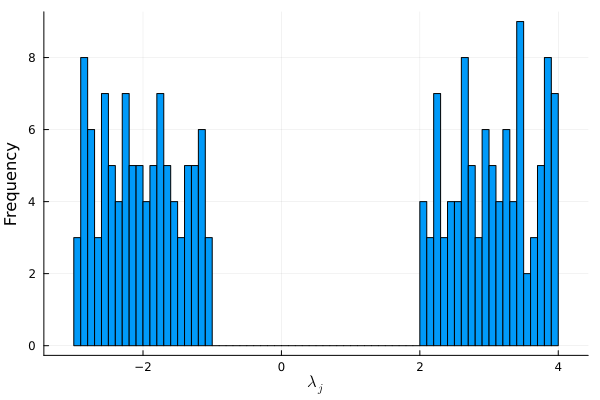

In [674]:
p1 = histogram(eigvals(A6),bins=80,label=:false)
xlabel!(L"\lambda_j")
ylabel!("Frequency")

In [675]:
#savefig(p1,"introplota.pdf")

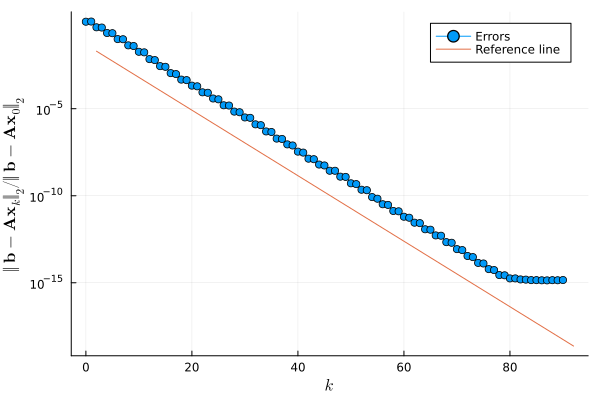

In [676]:
p1 = plot(0:length(residvec)-1,residvec,yaxis=:log,marker=:circle,label="Errors")
plot!(2:length(residvec)+1,abs(1/g₀).^((2.0.+(7:length(residvec)+6))),label="Reference line")
yticks!([10^-5, 10^-10, 10^-15])
xlabel!(L"k")
ylabel!(L"\Vert \mathbf{b}-\mathbf{A}\mathbf{x}_k\Vert_2/\Vert \mathbf{b}-\mathbf{A}\mathbf{x}_0\Vert_2")

In [677]:
#savefig(p1,"introplotb.pdf")

In [678]:
bands = [-2. -0.5; 0.5 6.]
maxpoly = 400
aveca = get_a(bands,0:maxpoly)
bveca = get_b(bands,0:maxpoly)
ints0a = map(n->CIp(bands,n,0.),0:maxpoly);

In [679]:
N = 200
i₁ = ceil(N*(bands[1,2]-bands[1,1])/(bands[1,2]-bands[1,1]+bands[2,2]-bands[2,1])) |> Int64;
μvec = zeros(N)
h₁ = (bands[1,2]-bands[1,1])/(i₁-1)
h₂ = (bands[2,2]-bands[2,1])/(N-i₁)
for i = 1:i₁
    μvec[i] = bands[1,1]+(i-1)*h₁
end
for i = i₁+1:N
    μvec[i] = bands[2,1]+(i-i₁)*h₂
end

In [680]:
A5 = diagm(μvec)
b5 = A5*ones(N);

In [681]:
@time (x,residvec) = akh_iter(A5,b5,aveca,bveca,ints0a,1.;maxiter=75)
g₀ = expg(bands,0.)
gz5 = map(z->expg(bands,z),eigvals(A5).+eps()im)
#gt = (maximum(abs.(gz5))/abs(g₀))[1]
gt = 1/abs(g₀)

  0.001399 seconds (1.80 k allocations: 1.559 MiB)


0.8642579755623623

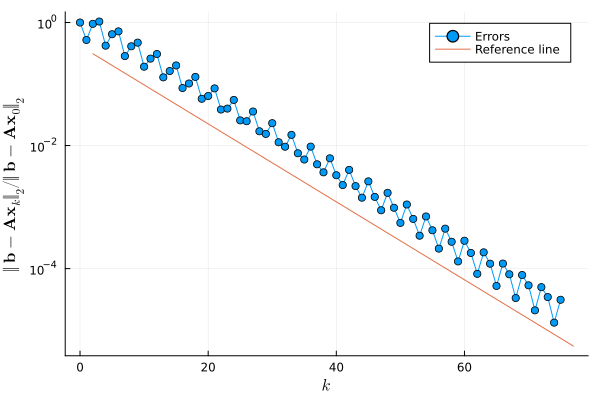

In [682]:
p1 = plot(0:length(residvec)-1,residvec,yaxis=:log,marker=:circle,label="Errors")
plot!(2:length(residvec)+1,abs(gt).^(8.0.+(0:length(residvec)-1)),label="Reference line")
xticks!([0, 20, 40, 60, 80])
yticks!([10^2, 10^0, 10^-2, 10^-4])
xlabel!(L"k")
ylabel!(L"\Vert \mathbf{b}-\mathbf{A}\mathbf{x}_k\Vert_2/\Vert \mathbf{b}-\mathbf{A}\mathbf{x}_0\Vert_2")

In [683]:
#savefig(p1,"saad_ex.pdf")

In [684]:
N = 200
n₁ = ceil(N*(bands[1,2]-bands[1,1])/(bands[1,2]-bands[1,1]+bands[2,2]-bands[2,1])) |> Int64;
Random.seed!(123)
μ₁ = M(bands[1,1],bands[1,2])(2*0.9*rand(n₁).-1)
μ₂ = M(bands[2,1],bands[2,2])(2*0.9*rand(N-n₁).-1)
A = diagm([μ₁; μ₂]);

In [685]:
Random.seed!(123)
A2 = A+0.3*randn(N,N)/sqrt(N);

In [686]:
Random.seed!(123)
P = rand(N,N)
Q,R = qr(P);

In [687]:
A4 = Q\(A2*Q)
b4 = A4*ones(N);

In [688]:
xv = bands[1,1]-0.2:0.05:bands[end,2]+0.2
yv = LinRange(-0.5,0.5,length(xv))
make_mat(x, y) = x+im*y
zv = @. make_mat(xv', yv);
gzp = map(z->log.(expg(bands,z)),zv);

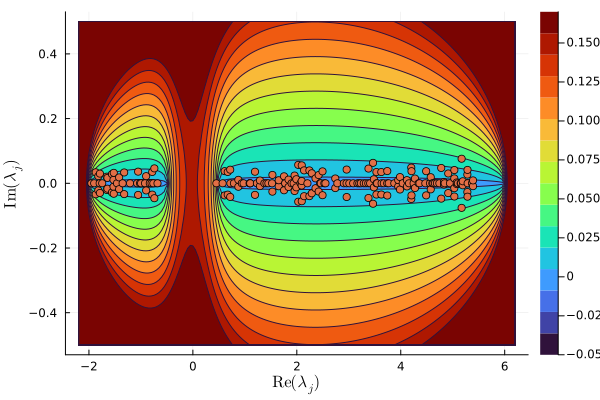

In [689]:
p1 = contourf(xv,yv,real.(gzp),clims=(-0.05,0.17),color=:turbo)
plot!(eigvals(A4),seriestype=:scatter,label=:false)
xlabel!(L"\mathrm{Re}(\lambda_j)")
ylabel!(L"\mathrm{Im}(\lambda_j)")
p1

In [690]:
#savefig(p1,"evals.pdf")

In [691]:
(x,residvec) = akh_iter(A4,b4,aveca,bveca,ints0a,1.;maxiter=370,tol=1e-16);

In [692]:
gz4 = map(z->expg(bands,z),eigvals(A4).+eps()im)
gt = (maximum(abs.(gz4))/abs(g₀))[1]

0.9179396564765063

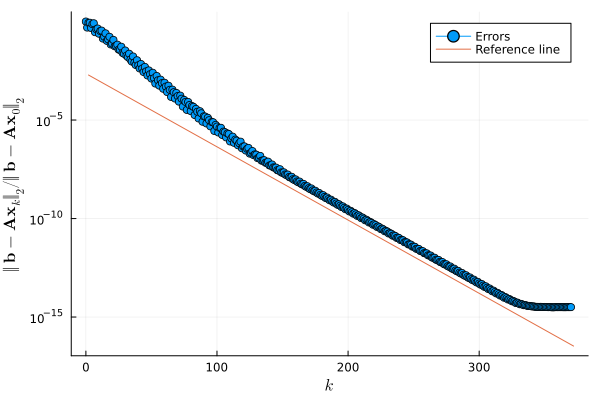

In [693]:
p1 = plot(0:length(residvec)-1,residvec,yaxis=:log,marker=:circle,label="Errors")
plot!(2:length(residvec)+1,abs(gt).^((2.0.+(71:length(residvec)+70))),label="Reference line")
yticks!([10^-5, 10^-10, 10^-15])
xlabel!(L"k")
ylabel!(L"\Vert \mathbf{b}-\mathbf{A}\mathbf{x}_k\Vert_2/\Vert \mathbf{b}-\mathbf{A}\mathbf{x}_0\Vert_2")

In [694]:
#savefig(p1,"iter_error.pdf")

In [695]:
mgrid = (n,L) -> -L .+ 2*L*(0:n-1)/n
zgrid = n -> exp.(1im*mgrid(n,pi))

#1035 (generic function with 1 method)

In [696]:
cc(j) = (bands[j,1]+bands[j,2])/2
rr(j) = 1.15*(bands[j,2]-bands[j,1])/2
g = size(bands,1)-1;

In [697]:
numpts = 200
ctrpts = []
ptsper = zeros(g+1) .|> Int
weights = []
for j = 1:g+1
    ptsper[j] = round(numpts*(bands[j,2]-bands[j,1]))
    append!(ctrpts,rr(j)*zgrid(ptsper[j]).+cc(j) .|> Complex)
    append!(weights,2π*im*rr(j)*(zgrid(ptsper[j]))/ptsper[j] .|> Complex)
end

In [698]:
intsa = zeros(ComplexF64,maxpoly+1,length(ctrpts))
for n = 0:maxpoly
    intsa[n+1,:] = map(x->CIp(bands,n,x),ctrpts)
end

In [699]:
Random.seed!(123)
br = rand(200);

In [700]:
(fAba,hist) = akh_func_hist(x->exp(x),A4,br,ctrpts,weights,aveca,bveca,intsa,1.);

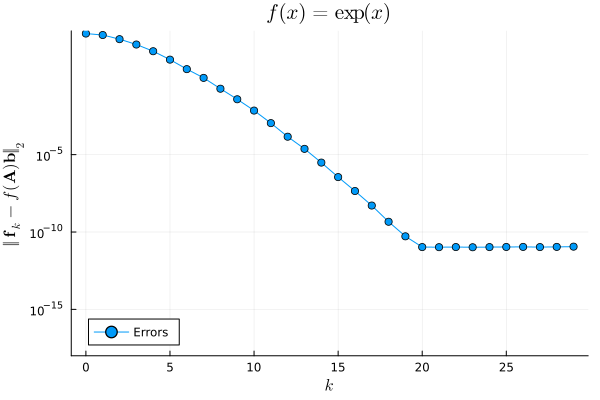

In [701]:
errmat = hist.-exp(A4)*br
mi = size(errmat,2)
errvec = zeros(mi)
for j = 1:mi
    errvec[j] = norm(errmat[:,j])
end
numiters = 29
p1 = plot(0:numiters,errvec[1:numiters+1],yaxis=:log,marker=:circle,label="Errors",legend=:bottomleft,ylim=(1e-18,1e3))
yticks!([10^-5, 10^-10, 10^-15])
#gtt = abs.(sum(gz))/length(gz)
gzz = map(z->expg(bands,z),ctrpts)
gz4 = map(z->expg(bands,z),eigvals(A4).+eps()im)
gtt1 = minimum(abs.(gzz))
gtt2 = maximum(abs.(gzz))
gt1 = maximum(abs.(gz4))/gtt1
gt2 = maximum(abs.(gz4))/gtt2
slopevec1 = abs(gt1).^(2.0.+(-45:mi))
slopevec2 = abs(gt2).^(2.0.+(-2:mi))
#plot!(0:numiters,slopevec1[1:numiters+1],label="Minimum reference line")
#plot!(0:numiters,slopevec2[1:numiters+1],label="Maximum covergence rate")
xlabel!(L"k")
ylabel!(L"\Vert \mathbf{f}_k-f(\mathbf{A})\mathbf{b}\Vert_2")
title!(L"f(x)=\exp(x)")

In [702]:
#savefig(p1,"exp_error.pdf")

In [703]:
(fAba,hist) = akh_func_hist(x->tanh(x),A,br,ctrpts,weights,aveca,bveca,intsa,1.);

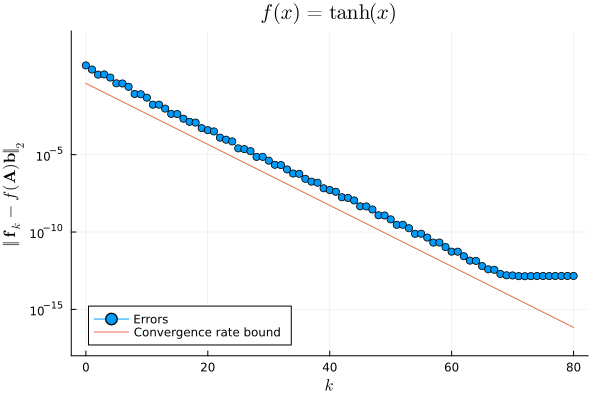

In [704]:
errmat = hist.-tanh(A)*br
mi = size(errmat,2)
errvec = zeros(mi)
for j = 1:mi
    errvec[j] = norm(errmat[:,j])
end
numiters = 80
p1 = plot(0:numiters,errvec[1:numiters+1],yaxis=:log,marker=:circle,label="Errors",legend=:bottomleft,ylim=(1e-18,1e3))
yticks!([10^-5, 10^-10, 10^-15])
#gtt = abs.(sum(gz))/length(gz)
gzz = map(z->expg(bands,z),ctrpts)
gz4 = map(z->expg(bands,z),eigvals(A4))
gtt1 = expg(bands,im*π/2)#minimum(abs.(gzz))
gtt2 = maximum(abs.(gzz))
gt1 = 1/gtt1
#gt2 = maximum(abs.(gz4))/gtt2
slopevec1 = abs(gt1).^(2.0.+(0:mi))
#slopevec2 = abs(gt2).^(2.0.+(-2:mi))
plot!(0:numiters,slopevec1[1:numiters+1],label="Convergence rate bound")
#plot!(0:numiters,slopevec2[1:numiters+1],label="Maximum covergence rate")
xlabel!(L"k")
ylabel!(L"\Vert \mathbf{f}_k-f(\mathbf{A})\mathbf{b}\Vert_2")
title!(L"f(x)=\tanh(x)")

In [705]:
#savefig(p1,"mat_func_erroras.pdf")

In [706]:
(fAba,hist) = akh_func_hist(x->tanh(x),A4,br,ctrpts,weights,aveca,bveca,intsa,1.);

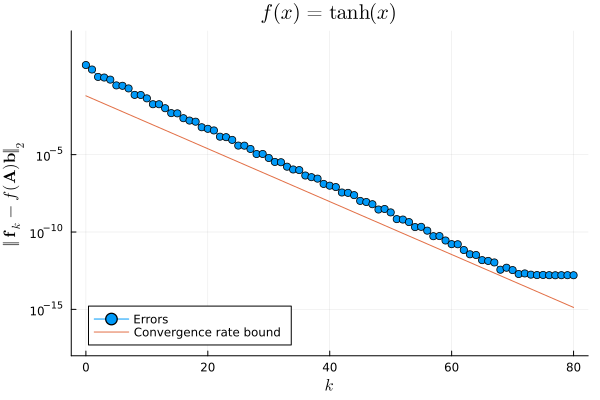

In [707]:
errmat = hist.-tanh(A4)*br
mi = size(errmat,2)
errvec = zeros(mi)
for j = 1:mi
    errvec[j] = norm(errmat[:,j])
end
numiters = 80
p1 = plot(0:numiters,errvec[1:numiters+1],yaxis=:log,marker=:circle,label="Errors",legend=:bottomleft,ylim=(1e-18,1e3))
yticks!([10^-5, 10^-10, 10^-15])
#gtt = abs.(sum(gz))/length(gz)
#gzz = map(z->expg(bands,z),ctrpts)
gz4 = map(z->expg(bands,z),eigvals(A4))
gtt1 = expg(bands,im*π/2)#minimum(abs.(gzz))
#gtt2 = maximum(abs.(gzz))
gt1 = maximum(abs.(gz4))/gtt1
#gt2 = maximum(abs.(gz4))/gtt2
slopevec1 = abs(gt1).^(2.0.+(5:mi))
#slopevec2 = abs(gt2).^(2.0.+(-2:mi))
plot!(0:numiters,slopevec1[1:numiters+1],label="Convergence rate bound")
#plot!(0:numiters,slopevec2[1:numiters+1],label="Maximum covergence rate")
xlabel!(L"k")
ylabel!(L"\Vert \mathbf{f}_k-f(\mathbf{A})\mathbf{b}\Vert_2")
title!(L"f(x)=\tanh(x)")

In [708]:
#savefig(p1,"mat_func_errora.pdf")

In [709]:
ft(x) = exp(x)/x#*exp(im*pi/4)
(fAbb,histb) = akh_func_hist(ft,A,br,ctrpts,weights,aveca,bveca,intsa,1.;maxiter=300);

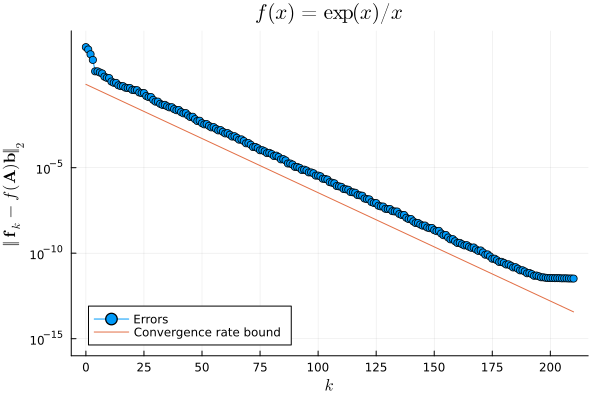

In [710]:
(lam,V) = eigen(A)
tru_fA = V*diagm(ft.(lam))/V
errmat = histb.-tru_fA*br
mi = size(errmat,2)
errvec = zeros(mi)
for j = 1:mi
    errvec[j] = norm(errmat[:,j])
end
numiters = 210
p1 = plot(0:numiters,errvec[1:numiters+1],yaxis=:log,marker=:circle,label="Errors",legend=:bottomleft,ylim=(1e-16,1e3))
yticks!([10^-5, 10^-10, 10^-15])
xticks!(0:25:300)
#gtt = abs.(sum(gz))/length(gz)
#gzz = map(z->expg(bands,z),ctrpts)
gz4 = map(z->expg(bands,z),eigvals(A4).+eps()im)
gtt1 = expg(bands,0.)#minimum(abs.(gzz))
#gtt2 = maximum(abs.(gzz))
gt1 = 1/gtt1
#gt2 = maximum(abs.(gz4))/gtt2
slopevec1 = abs(gt1).^(2.0.+(0:350))
#slopevec2 = abs(gt2).^(2.0.+(-6:mi))
plot!(0:numiters,slopevec1[1:numiters+1],label="Convergence rate bound")
#plot!(0:numiters,slopevec2[1:numiters+1],label="Maximum covergence rate")
xlabel!(L"k")
ylabel!(L"\Vert \mathbf{f}_k-f(\mathbf{A})\mathbf{b}\Vert_2")
title!(L"f(x)=\exp(x)/x")

In [711]:
#savefig(p1,"mat_func_errorbs.pdf")

In [712]:
ft(x) = exp(x)/x#*exp(im*pi/4)
(fAbb,histb) = akh_func_hist(ft,A4,br,ctrpts,weights,aveca,bveca,intsa,1.;maxiter=300);

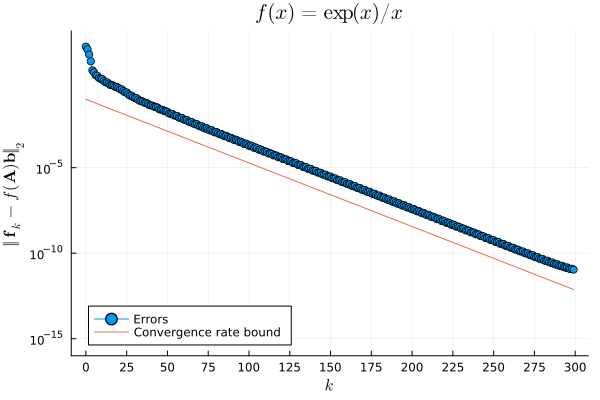

In [713]:
(lam,V) = eigen(A4)
tru_fA = V*diagm(ft.(lam))/V
errmat = histb.-tru_fA*br
mi = size(errmat,2)
errvec = zeros(mi)
for j = 1:mi
    errvec[j] = norm(errmat[:,j])
end
numiters = 299
p1 = plot(0:numiters,errvec[1:numiters+1],yaxis=:log,marker=:circle,label="Errors",legend=:bottomleft,ylim=(1e-16,1e3))
yticks!([10^-5, 10^-10, 10^-15])
xticks!(0:25:300)
#gtt = abs.(sum(gz))/length(gz)
#gzz = map(z->expg(bands,z),ctrpts)
gz4 = map(z->expg(bands,z),eigvals(A4).+eps()im)
gtt1 = expg(bands,0.)#minimum(abs.(gzz))
#gtt2 = maximum(abs.(gzz))
gt1 = maximum(abs.(gz4))/gtt1
#gt2 = maximum(abs.(gz4))/gtt2
slopevec1 = abs(gt1).^(2.0.+(25:350))
#slopevec2 = abs(gt2).^(2.0.+(-6:mi))
plot!(0:numiters,slopevec1[1:numiters+1],label="Convergence rate bound")
#plot!(0:numiters,slopevec2[1:numiters+1],label="Maximum covergence rate")
xlabel!(L"k")
ylabel!(L"\Vert \mathbf{f}_k-f(\mathbf{A})\mathbf{b}\Vert_2")
title!(L"f(x)=\exp(x)/x")

In [714]:
#savefig(p1,"mat_func_errorb.pdf")

In [638]:
bands2 = [-2.0 -0.5; 0.5 0.7; 5.8 6.0]
g = size(bands2,1)-1
N = 200
n₁ = ceil(N*(bands2[1,2]-bands2[1,1])/(bands2[1,2]-bands2[1,1]+bands2[2,2]-bands2[2,1]+bands2[3,2]-bands2[3,1])) |> Int64;
n₂ = ceil(N*(bands2[2,2]-bands2[2,1])/(bands2[1,2]-bands2[1,1]+bands2[2,2]-bands2[2,1]+bands2[3,2]-bands2[3,1])) |> Int64;

In [639]:
Random.seed!(123)
μ₁ = M(bands2[1,1],bands2[1,2])(2*0.9*rand(n₁).-1)
μ₂ = M(bands2[2,1],bands2[2,2])(2*0.9*rand(n₂).-1)
μ₃ = M(bands2[3,1],bands2[3,2])(2*0.9*rand(N-n₁-n₂).-1)
A6 = Q\((diagm([μ₁; μ₂; μ₃])+0.1*randn(N,N)/sqrt(N))*Q);
b6 = A6*ones(N);

In [640]:
(x,residvec) = akh_iter(A6,b6,aveca,bveca,ints0a,1.;maxiter=250,tol=1e-10)
length(residvec)-1

177

In [641]:
gz6 = map(z->expg(bands,z),eigvals(A6).+eps()im)
gt = (maximum(abs.(gz6))/abs(g₀))[1]

0.8889069060477426

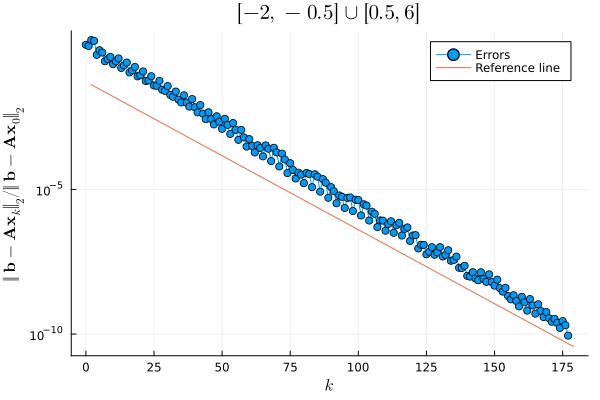

In [642]:
p1 = plot(0:length(residvec)-1,residvec,yaxis=:log,marker=:circle,label="Errors")
plot!(2:length(residvec)+1,abs(gt).^((2.0.+(25:length(residvec)+24))),label="Reference line")
yticks!([10^-5, 10^-10, 10^-15])
xticks!([0, 25, 50, 75, 100, 125, 150, 175])
xlabel!(L"k")
ylabel!(L"\Vert \mathbf{b}-\mathbf{A}\mathbf{x}_k\Vert_2/\Vert \mathbf{b}-\mathbf{A}\mathbf{x}_0\Vert_2")
title!(L"[-2,-0.5]\cup[0.5,6]")

In [643]:
#savefig(p1,"2v3a.pdf")

In [644]:
(avec,bvec,ints,gz0)=get_n_coeffs_and_ints_no_circ(bands2,600,0.0);

In [645]:
eigvals(A5)

200-element Vector{Float64}:
 -2.0
 -1.9642857142857142
 -1.9285714285714286
 -1.8928571428571428
 -1.8571428571428572
 -1.8214285714285714
 -1.7857142857142858
 -1.75
 -1.7142857142857144
 -1.6785714285714286
 -1.6428571428571428
 -1.6071428571428572
 -1.5714285714285714
  ⋮
  5.614649681528662
  5.649681528662421
  5.6847133757961785
  5.719745222929936
  5.754777070063694
  5.789808917197452
  5.82484076433121
  5.859872611464968
  5.894904458598726
  5.929936305732484
  5.964968152866242
  6.0

In [646]:
(x,residvec) = akh_iter(A6,b6,avec,bvec,ints,special_weight_int(bands2);maxiter=250,tol=1e-10)
length(residvec)-1

102

In [647]:
@time (~,~,~,gzz6)=get_n_coeffs_and_ints_no_circ(bands2,0,eigvals(A6).+eps()im)
gtt = (maximum(abs.(exp.(gzz6)))/abs.(exp.(gz0)))[1]

  0.764374 seconds (2.84 M allocations: 147.222 MiB, 8.95% gc time, 91.06% compilation time)


0.7872255911997482

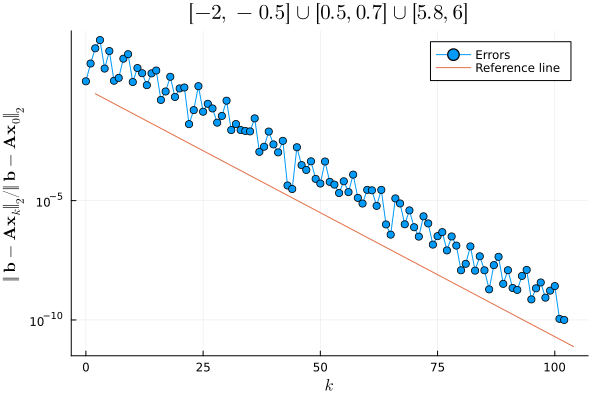

In [648]:
p1 = plot(0:length(residvec)-1,residvec,yaxis=:log,marker=:circle,label="Errors")
plot!(2:length(residvec)+1,gtt.^((2.0.+(3:length(residvec)+2))),label="Reference line")
xticks!([0, 25, 50, 75, 100, 125, 150, 175])
yticks!([10^-5, 10^-10, 10^-15])
xlabel!(L"k")
ylabel!(L"\Vert \mathbf{b}-\mathbf{A}\mathbf{x}_k\Vert_2/\Vert \mathbf{b}-\mathbf{A}\mathbf{x}_0\Vert_2")
title!(L"[-2,-0.5]\cup[0.5,0.7]\cup[5.8,6]")

In [649]:
#savefig(p1,"2v3b.pdf")

### Laplacian example

$$-u_{xx}+f_1u=f_2$$

In [715]:
N = 100
h = 1/(N+1)
f₁(x) = -30exp(x)
f₂(x) = x

f₂ (generic function with 1 method)

In [716]:
L = diagm(-1 => -ones(N-1), 0 => 2.0 * ones(N), 1 => -ones(N-1)) / h^2
xvec = 0:h:1
xvec = xvec[2:end-1]
rhs = f₂.(xvec)
A = L + diagm(f₁.(xvec))
Ap = L\A
rhsp = L\rhs
eigvals(Ap)

100-element Vector{Float64}:
 -4.149280975661184
 -0.2816852262609691
  0.43062260434426725
  0.6796330167724716
  0.7948365736184478
  0.8574021455707934
  0.8951222806449913
  0.9196020049158721
  0.936384169945098
  0.9483877337918936
  0.9572685917556699
  0.9640228883503634
  0.9692790457482551
  ⋮
  0.9988719538193424
  0.998899783866248
  0.9989277249559145
  0.9989558433731416
  0.998984223842403
  0.9990129779851769
  0.9990422585199688
  0.9990722848537843
  0.9991033937833003
  0.9991361543590114
  0.9991716883830302
  0.9992129882646117

In [717]:
tru_bands = optim_bands_ev([-2. -0.5; 0.5 1.],Ap)

2×2 Matrix{Float64}:
 -4.14928   -0.281685
  0.430623   1.0

In [718]:
bandso = optim_bands([-2. -0.5; 0.5 1.],Ap,rhsp,5.,0.7)

2×2 Matrix{Float64}:
 -4.16236   -0.248536
  0.251043   3.10107

In [719]:
gzp = map(z->expg(bandso,z),eigvals(Ap).+eps()im)
maximum(abs.(gzp))
gz0=abs(expg(bandso,0.))
maximum(abs.(gzp))/gz0

0.9327265109299351

In [720]:
maxpoly = 600
aveca = get_a(bandso,0:maxpoly)
bveca = get_b(bandso,0:maxpoly)
ints0a = map(n->CIp(bandso,n,0.),0:maxpoly);

In [721]:
(x,residvec) = akh_iter(Ap,rhsp,aveca,bveca,ints0a,1.;maxiter=250);

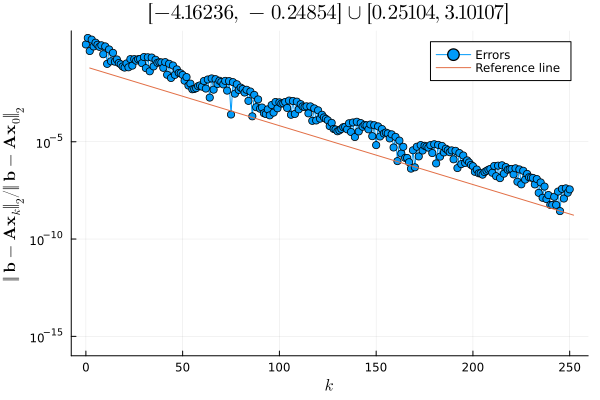

In [722]:
p1 = plot(0:length(residvec)-1,residvec,yaxis=:log,marker=:circle,label="Errors",ylim=(1e-16,5))
plot!(2:length(residvec)+1,(maximum(abs.(gzp))/gz0).^((2.0.+(38:length(residvec)+37))),label="Reference line")
xlabel!(L"k")
ylabel!(L"\Vert \mathbf{b}-\mathbf{A}\mathbf{x}_k\Vert_2/\Vert \mathbf{b}-\mathbf{A}\mathbf{x}_0\Vert_2")
yticks!([10^-5, 10^-10, 10^-15])
title!(L"[-4.16236,-0.24854]\cup[0.25104, 3.10107]")

In [723]:
#savefig(p1,"schroda.pdf")

In [724]:
bandsoi = optim_bands_improved([-2.0 -0.5; 0.5 1.0],Ap,rhsp,5.,0.7)

2×2 Matrix{Float64}:
 -4.15388   -0.28391
  0.441676   1.01575

In [725]:
maxpoly = 600
avecai = get_a(bandsoi,0:maxpoly)
bvecai = get_b(bandsoi,0:maxpoly)
ints0ai = map(n->CIp(bandsoi,n,0.),0:maxpoly);
gzp = map(z->expg(bandsoi,z),eigvals(Ap))
gz0=abs(expg(bandsoi,0.))
maximum(abs.(gzp))/gz0

0.8789705972085056

In [726]:
(x,residvec) = akh_iter(Ap,rhsp,avecai,bvecai,ints0ai,1.;maxiter=250,tol=1e-16);

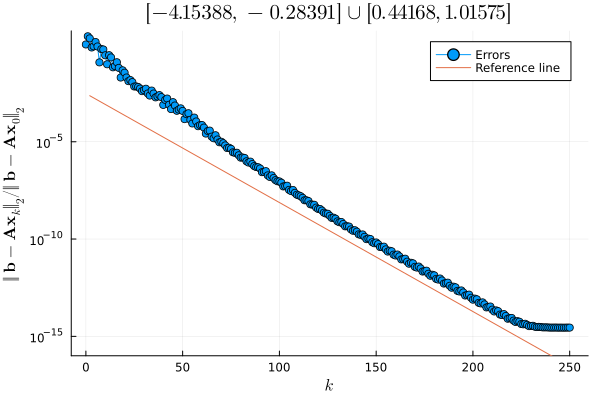

In [727]:
p1 = plot(0:length(residvec)-1,residvec,yaxis=:log,marker=:circle,label="Errors",ylim=(1e-16,5))
plot!(2:length(residvec)+1,(maximum(abs.(gzp))/gz0).^((2.0.+(45:length(residvec)+44))),label="Reference line")
xlabel!(L"k")
ylabel!(L"\Vert \mathbf{b}-\mathbf{A}\mathbf{x}_k\Vert_2/\Vert \mathbf{b}-\mathbf{A}\mathbf{x}_0\Vert_2")
yticks!([10^-5, 10^-10, 10^-15])
title!(L"[-4.15388,-0.28391]\cup[0.44168, 1.01575]")

In [663]:
#savefig(p1,"schrodb.pdf")